# Fischer Linear Discriminant Analysis
Also known as Linear Discriminant Analysis (LDA), it is a supervised learning technique that focuses on discrimination of different classes. This notebook will give an example of using it and visualizing teh transformations on the make_blobs() dataset.

In [1]:
# Necessary imports
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from utils.plots import display_data, display_data_3d, animate_data_3d

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from linear_discriminant_analysis.fischer_lda import FischerLDA
from utils.metrics import class_accuracy

# 1. The Blobs
First, let's create the dataset. We'll make 8 different blobs in 3D space:

In [2]:
# Creates the dataset
X, y = make_blobs(n_samples=1000, n_features=3, centers=8, random_state=0)

# Train / test split of 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

We can view a 3D plot of this data (see `examples/rotating_blob.mp4` for an animated view of other angles).

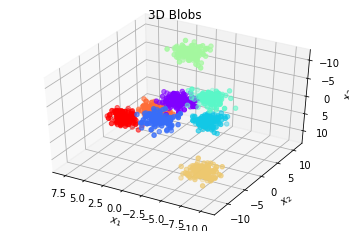

In [3]:
display_data_3d(X, y, title='3D Blobs', legend=False, view_init=(-140,60))

Here is a 2D projection of the data.

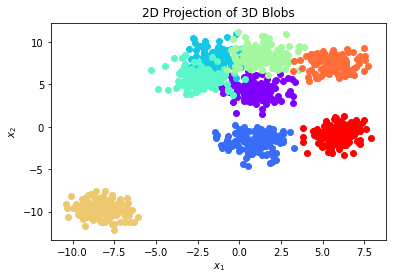

In [4]:
# Make an inline plot
display_data(X, y, title='2D Projection of 3D Blobs', legend=False)

## 2. Training the Model
Though there is some separability already in the data, LDA can make it better through clever dimensionality reduction. This projection will maximize the between-class variance, while minimizing the within-class variance. The model will output (in this case) 2 eigenvectors that are used for the transformation. The model also saves the class covariances and means in the Fischer space to be used in the classification process.

In [5]:
# Initializes an LDA model that will reduce the dimensions of the data to 2
model = FischerLDA(num_components=2)

# Creates the Fischer LDF from the training set
model.fit(X_train, y_train)

# The most-significant eigenvectors; used to tranform the data to Fischer space
print('Optimal eigenvectors: \n', model.h)

Optimal eigenvectors: 
 [[-0.40879716  0.45877731]
 [-0.78635953  0.2548384 ]
 [ 0.4631669   0.8512231 ]]


Now that the optimal eigenvectors have been found, we can view the dataset in the new Fischer space.
The new Fischer space is in 2D (reduced from the original 3D), so a 2D plot is sufficient to represent the data.

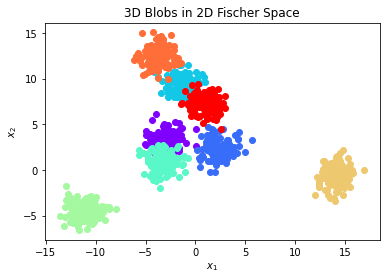

In [6]:
display_data(X @ model.h, y, title='3D Blobs in 2D Fischer Space', legend=False)

# 3. Classifying Data
The classes show an improvement in their separability, which helps in predicting classification. LDA gives the covariances and means for each class, which allows for making predictions through the use of the Mahalanobis distance. Predicting labels becomes a matter of calculating which class is closest to the datapoint using this metric.

LDF Accuracy: 93.5%

Confusion Matrix:


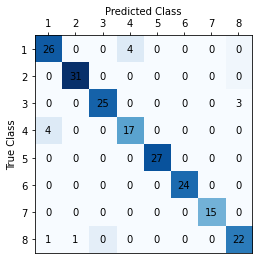

In [7]:
predictions = model.predict(X_test)

print('LDF Accuracy: {}%'.format(100 * class_accuracy(predictions, y_test)))

conf_matrix = confusion_matrix(y_test, predictions)

# Prints the confusion matrix
print("\nConfusion Matrix:")
fig, ax = plt.subplots()
ax.imshow(conf_matrix, cmap='Blues')
s = conf_matrix.shape[0]
for i in range(s):
    for j in range(s):
        c = int(conf_matrix[i,j])
        ax.text(i, j, str(c), va='center', ha='center')
ax.set_xlabel('Predicted Class')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('True Class')
ax.set_xticks(np.arange(s))
ax.set_xticklabels(np.arange(1,s+1))
ax.xaxis.tick_top()
ax.set_yticks(np.arange(s))
ax.set_yticklabels(np.arange(1,s+1))
plt.show()

If we calculate the class means and scatter matrices (what is used instead of covariances, as they are proportional) on the original data, we can compare how the performance is impacted by transforming the data into the Fischer space.

In [8]:
# Gets the number of classes
class_count = np.unique(y_train).shape[0]

# Splits the data by class
X_t_split = np.array([X_train[y_train == i] for i in range(class_count)])

# Finds the class means
class_means = np.array([np.mean(X_t_split[i],axis=0) for i in range(class_count)])
# Finds the scatter matrices (proportional to covariances) for classes
# (uses model function to accomplish)
scatters = [model.class_scatter(X_t_split[c], class_means[c]) for c in range(class_count)]

def predict(X):
    """Predicts the label of the data given in input."""
    # Shifts the data by the fischer class mean
    classes_shift = np.array([X - class_means[c] for c in range(class_count)])
    # Calculates the mahalanobis distance for each datapoint in each class
    d = np.array([[(classes_shift[c,i].T @ scatters[c]) @ classes_shift[c,i] \
        for c in range(class_count)] for i in range(X.shape[0])])
    # Gets the class with the smallest mahal. distance for each datapoint
    chosen_classes = np.argmin(d, axis=1)
    return chosen_classes

original_predictions = predict(X_test)

Here we show the accuracy of our data before being put in the Fischer space:

Original Accuracy: 98.0%

Confusion Matrix:


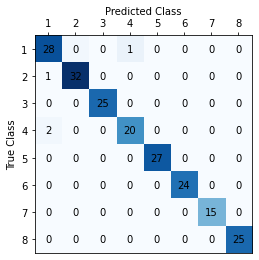

In [9]:
print('Original Accuracy: {}%'.format(100 * class_accuracy(original_predictions, y_test)))

conf_matrix = confusion_matrix(y_test, original_predictions)

# Prints the confusion matrix
print("\nConfusion Matrix:")
fig, ax = plt.subplots()
ax.imshow(conf_matrix, cmap='Blues')
s = conf_matrix.shape[0]
for i in range(s):
    for j in range(s):
        c = int(conf_matrix[i,j])
        ax.text(i, j, str(c), va='center', ha='center')
ax.set_xlabel('Predicted Class')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('True Class')
ax.set_xticks(np.arange(s))
ax.set_xticklabels(np.arange(1,s+1))
ax.xaxis.tick_top()
ax.set_yticks(np.arange(s))
ax.set_yticklabels(np.arange(1,s+1))
plt.show()

As seen here, being discriminant will not necessarilly lead to improved accuracy, but it does allow for effective dimensionality reduction while maintaining good prediction accuracy.